# Exercises Week 9 in 02506: Developing a Neural Network for MNIST 

The dataset can be downloaded [as .gz files here](http://yann.lecun.com/exdb/mnist/).

<p align="center"> 
  <img src="../MNIST/raw/MNIST_images_train/image_train_00000.png" width="300" title="Very simple NN">
</p>

### Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import cv2
from skimage.io import imshow
import random
import torch

# import data handler
from datahandler import *

# for transformations
import torchvision.transforms as transforms

# Importing UNet
from UNet import *

# Importing dice loss
from torchgeometry.losses import dice

### Defining on Load Transformations

In [23]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

img_trans = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomCrop(128,20),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(degrees = 45),
                                transforms.ToTensor(),
                                transforms.Normalize((0),(1)),
                                AddGaussianNoise(std=0.05)
                                ])

lab_trans = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomCrop(128,20),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(degrees = 45),
                                transforms.ToTensor()
                                ])

### Pre-processing of Data

torch.Size([10, 1, 128, 128])
torch.Size([10, 1, 128, 128])


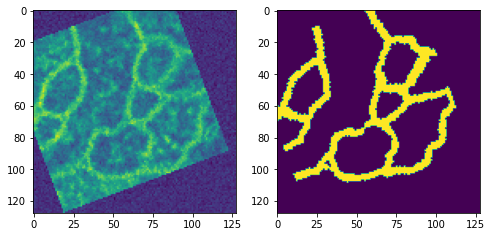

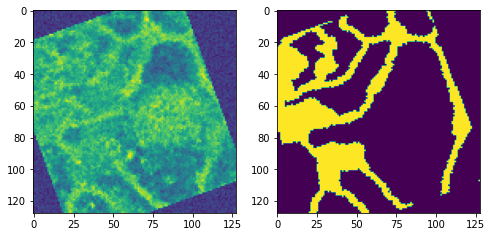

In [24]:
data_dir=r'./'
subset='train'
im_id=range(1,31)    
TrainData = DataHandler(
    data_dir, 
    im_id, 
    subset,
    is_ubuntu=True,
    img_trans=img_trans,
    lab_trans=lab_trans)

a,b=TrainData.__getitem__(2)

# Define dataloader 
train_loader = DataLoader(dataset = TrainData, 
                                           batch_size = 10,
                                           shuffle = False,
                                           num_workers = 0)

pbar = enumerate(train_loader)
train_loss = []
for i, (images,target) in pbar:
    print(images.shape)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,10))
    ax1.imshow(images.numpy()[0][0])
    ax2.imshow(target.numpy()[0][0])
    break
for i, (images,target) in pbar:
    print(images.shape)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,10))
    ax1.imshow(images.numpy()[0][0])
    ax2.imshow(target.numpy()[0][0])
    break

### Defining Loss and Optimizer

In [42]:
#%% parameters
lr = 0.0001

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
else:
    device = torch.device('cpu')
    print('Using cpu')

# number of channels for the network
c = 16
model = UNet(c)

loss_function = torch.nn.BCELoss() # dice.DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.0001)


#%%
train_loader = DataLoader(dataset = TrainData, 
                                           batch_size = 10,
                                           shuffle = True,
                                           num_workers = 0)



Using cpu


### Defining Accuracy

In [43]:
def accuracy(y,t):
    y = np.round(y.detach().numpy())
    t = np.round(t.detach().numpy())
    B,M,N = np.shape(y)
    return  np.sum(y.flatten() == t.flatten())/(B*M*N)

### Defining F1 Score

In [44]:
def recall(tp,fn):
    return tp/(tp+fn+1e-9)

def precision(tp,fp):
    return tp/(tp+fp+1e-9)

def F1(y,t):
    y = np.round(y.clone().detach().requires_grad_(False).numpy()).flatten().astype(int)
    t = np.round(t.clone().detach().requires_grad_(False).numpy()).flatten().astype(int)

    # True positives
    idx = t == 1
    tp = np.sum(y[idx] == t[idx])

    # False negatives
    fn = np.sum(y[idx] != t[idx])

    # False positives
    idx = y == 1
    fp = np.sum(y[idx] != t[idx])

    p = precision(tp,fp)
    r = recall(tp,fn)
    return p,r,2*p*r/(p+r+1e-9)

### Training  the network

In [46]:
train_loss = []
train_acc = []
train_prec = []
train_rec = []
train_f1 = []
val_loss = []
val_acc = []

epochs = 10

N_train = len(train_loader)
N_test = 0
print(f"There are {N_train} training and {N_test} test batches")
for e in range(epochs):
    train_l = 0
    train_a = 0
    train_p = 0
    train_r = 0
    train_f = 0
    model.train()
    for i,tmp in enumerate(train_loader):
        x,t = tmp
        optimizer.zero_grad()
        y = model.forward(x)
        t = torch.round(t)
        #print(y[:,1,:,:].shape)
        #print(y[0,:,0,0])
        #print(t[:,0,:,:].shape)
        # ytemp = torch.zeros(t.shape) + y[:,1,:,:]
        loss = loss_function(y[:,1,:,:],t[:,0,:,:])
        train_l += loss.item()
        loss.backward()
        optimizer.step()

        # Accuracy
        train_a += accuracy(y[:,1,:,:],t[:,0,:,:])

        # Precision, recall and F1
        p,r,f1 = F1(y[:,1,:,:],t[:,0,:,:])
        train_p += p
        train_r += r
        train_f += f1

    train_loss.append(train_l/N_train)
    train_acc.append(train_a/N_train)
    train_prec.append(train_p/N_train)
    train_rec.append(train_r/N_train)
    train_f1.append(train_f/N_train)
    model.eval()
    print(f"Finished epoch {e+1} of {epochs}. The loss is {train_l/N_train} and the accuracy is {train_a/N_train}")

There are 48 training and 0 test batches
Finished epoch 1 of 10. The loss is 0.6806117991606394 and the accuracy is 0.6142903645833333
Finished epoch 2 of 10. The loss is 0.539924111838142 and the accuracy is 0.8294483184814454
Finished epoch 3 of 10. The loss is 0.4293023894230525 and the accuracy is 0.8277778625488281
Finished epoch 4 of 10. The loss is 0.34008498179415864 and the accuracy is 0.8290342966715493
Finished epoch 5 of 10. The loss is 0.2991192837556203 and the accuracy is 0.8493232727050781
Finished epoch 6 of 10. The loss is 0.27992810495197773 and the accuracy is 0.8737683614095052
Finished epoch 7 of 10. The loss is 0.2685676521311204 and the accuracy is 0.8798988342285158
Finished epoch 8 of 10. The loss is 0.25947377923876047 and the accuracy is 0.8835187276204427
Finished epoch 9 of 10. The loss is 0.2545787493387858 and the accuracy is 0.8847480773925782
Finished epoch 10 of 10. The loss is 0.2521848852435748 and the accuracy is 0.8851511637369792


### Evaluating the Network

<bound method Figure.show of <Figure size 864x648 with 4 Axes>>

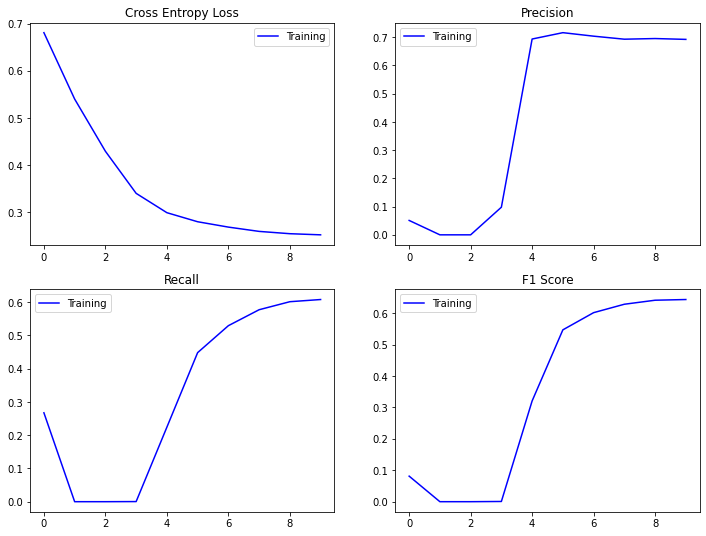

In [47]:

axlen = len(train_loss)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,9))
ax1.plot(range(0,axlen),train_loss,c = 'blue',label='Training')
#ax1.plot(range(0,epochs),val_loss,c = 'orange',label='Validation')
ax1.legend()
ax1.set_title("Cross Entropy Loss")

ax2.plot(range(0,axlen),train_prec,c = 'blue',label='Training')
#ax2.plot(range(0,epochs),val_acc,c = 'orange',label='Validation')
ax2.legend()
ax2.set_title("Precision")

ax3.plot(range(0,axlen),train_rec,c = 'blue',label='Training')
#ax3.plot(range(0,epochs),val_acc,c = 'orange',label='Validation')
ax3.legend()
ax3.set_title("Recall")

ax4.plot(range(0,axlen),train_f1,c = 'blue',label='Training')
#ax4.plot(range(0,epochs),val_acc,c = 'orange',label='Validation')
ax4.legend()
ax4.set_title("F1 Score")

fig.show

### Some examples of the Classification

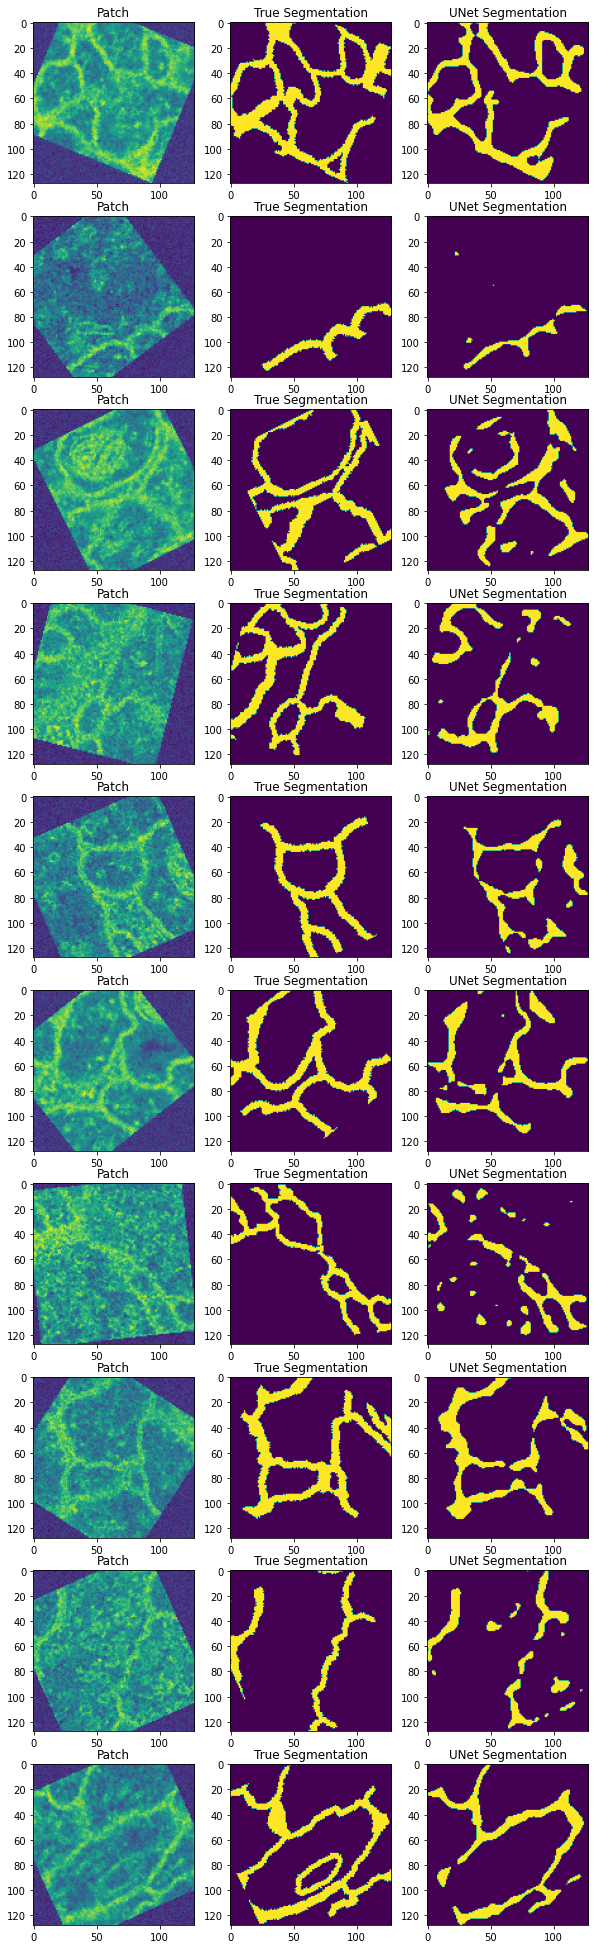

In [49]:
for i,tmp in enumerate(train_loader):
    x,t = tmp
    y = model.forward(x)
    t = torch.round(t)
    m = x.shape[0]
    n = 3

    fig, ax = plt.subplots(m,n,figsize=(10,3.5*m))

    for i in range(m):
        ax[i][0].imshow(x[i,0,:,:].detach().numpy())
        ax[i][0].set_title("Patch")
        ax[i][1].imshow(np.round(t[i,0,:,:].detach().numpy()))
        ax[i][1].set_title("True Segmentation")
        ax[i][2].imshow(np.round(y[i,1,:,:].detach().numpy()))
        ax[i][2].set_title("UNet Segmentation")

    break